In [3]:
### Setup Environment ###
import numpy as np
import pandas as pd
import plotly_express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy.stats import chi2_contingency
from mlxtend.feature_selection import ExhaustiveFeatureSelector as EFS
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
import statsmodels.api as sm
from itertools import combinations

np.set_printoptions(suppress=True, formatter={'float_kind':'{:0.4f}'.format})
pd.set_option('display.float_format', lambda x: '%.4f' % x)
pd.set_option('display.max_rows', None)

from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif, f_classif, SelectKBest, SelectFromModel, SequentialFeatureSelector
from sklearn.linear_model import Lasso, LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import roc_auc_score, r2_score, accuracy_score
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('matchups_2010.csv')
df = df[df['round'] == 'Second Round']
print(df.shape)
df.head()

(224, 46)


,year,region,round,high_bracket_seed,high_bracket_team,low_bracket_seed,low_bracket_team,win,wab,prpg!,...,2p%d,3p%d,blk%,ast%d,3prd,ft%d,height,size,experience,bench
1,2010,Midwest,Second Round,1,2010 Kansas,9,2010 Northern Iowa,0,7.8068,0.0000,...,-7.7000,-2.3000,9.7000,6.0000,-5.5000,-7.7000,1.7900,0.6000,-0.5200,-3.6900
4,2010,Midwest,Second Round,5,2010 Michigan St.,4,2010 Maryland,1,0.1860,-5.6000,...,-4.6000,-6.3000,1.0000,1.3000,12.7000,-0.8000,-0.6400,-1.2900,-0.4000,5.6500
10,2010,Midwest,Second Round,6,2010 Tennessee,14,2010 Ohio,1,11.4782,-0.4000,...,-0.8000,-6.5000,1.9000,-5.6000,2.8000,-3.7000,0.3000,1.2700,0.5700,10.9500
13,2010,Midwest,Second Round,10,2010 Georgia Tech,2,2010 Ohio St.,0,-4.2740,-12.1000,...,-13.5000,-7.6000,8.2000,2.5000,0.2000,-2.2000,3.9500,0.6200,-0.7300,19.8900
17,2010,West,Second Round,1,2010 Syracuse,8,2010 Gonzaga,1,4.9630,-1.1000,...,-8.3000,-5.5000,10.6000,14.3000,12.6000,-2.8000,-2.6000,0.2400,0.4600,-0.1400


In [4]:
df['win'].value_counts(normalize=True)

0   0.5089
1   0.4911
Name: win, dtype: float64

In [5]:
eda_df = df[[
    'win', 
    'wab', 
    'prpg!', 
    'dprpg',
    'bpm', 
    'obpm', 
    'dbpm', 
    'kenpom_adjem',
    'kenpom_adjoe', 
    'kenpom_adjde', 
    'barthag', 
    'barthag_oe', 
    'barthag_de',
    'off_eff', 
    'def_eff', 
    'efg%',
    'ftr', 
    'tor', 
    'orb%', 
    'efgd%', 
    'ftrd',
    'tord', 
    'drb%', 
    '2p%', 
    '3p%', 
    'blked%', 
    'ast%', 
    '3pr', 
    'ft%', 
    '2p%d',
    '3p%d', 
    'blk%', 
    'ast%d', 
    '3prd', 
    'ft%d', 
    'height', 
    'size', 
    'experience',
    'bench']]

In [6]:
# Split dataset into a train and test set
X = eda_df.iloc[:,1:]
Y = eda_df['win']

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.3, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

print(train_df.shape)
print(test_df.shape)

(156, 39)
(68, 39)


# I. Numerical Tests

In [7]:
corr_matrix = train_df.corr()
correlation_with_target = round(abs(corr_matrix['win'])*100,2)
correlation_with_target = correlation_with_target[correlation_with_target >= 20]
print(correlation_with_target)

wab             45.9500
prpg!           49.0600
dprpg           41.2000
bpm             54.1100
obpm            46.4300
dbpm            41.0200
kenpom_adjem    49.9500
kenpom_adjoe    37.3900
kenpom_adjde    33.3900
barthag         44.4200
barthag_oe      40.4400
barthag_de      33.0100
off_eff         28.2200
def_eff         22.9600
ftrd            21.1500
height          23.4000
size            26.0800
bench           29.0500
win            100.0000
Name: win, dtype: float64


In [8]:
X = train_df.drop('win', axis=1)
y = train_df['win']

# ANOVA
f_values, p_values = f_classif(X, y)
# Mutual Information
mi = mutual_info_regression(X, y)

column_names = np.array(X.columns)
stats_df = pd.DataFrame({
    'feature': column_names,
    'f_values': f_values,
    'p_values': p_values,
    'mutual_info': mi
})
stats_df

,feature,f_values,p_values,mutual_info
0,wab,41.2072,0.0000,0.0872
1,prpg!,48.8065,0.0000,0.1697
2,dprpg,31.4758,0.0000,0.0897
3,bpm,63.7651,0.0000,0.1512
4,obpm,42.3131,0.0000,0.1317
5,dbpm,31.1567,0.0000,0.0547
6,kenpom_adjem,51.1943,0.0000,0.1643
7,kenpom_adjoe,25.0251,0.0000,0.0528
8,kenpom_adjde,19.3212,0.0000,0.0535
9,barthag,37.8515,0.0000,0.1082


In [9]:
stats_df[stats_df['mutual_info'] > .05]

,feature,f_values,p_values,mutual_info
0,wab,41.2072,0.0000,0.0872
1,prpg!,48.8065,0.0000,0.1697
2,dprpg,31.4758,0.0000,0.0897
3,bpm,63.7651,0.0000,0.1512
4,obpm,42.3131,0.0000,0.1317
5,dbpm,31.1567,0.0000,0.0547
6,kenpom_adjem,51.1943,0.0000,0.1643
7,kenpom_adjoe,25.0251,0.0000,0.0528
8,kenpom_adjde,19.3212,0.0000,0.0535
9,barthag,37.8515,0.0000,0.1082


In [10]:
stats_df[stats_df['p_values'] < .05]

,feature,f_values,p_values,mutual_info
0,wab,41.2072,0.0000,0.0872
1,prpg!,48.8065,0.0000,0.1697
2,dprpg,31.4758,0.0000,0.0897
3,bpm,63.7651,0.0000,0.1512
4,obpm,42.3131,0.0000,0.1317
5,dbpm,31.1567,0.0000,0.0547
6,kenpom_adjem,51.1943,0.0000,0.1643
7,kenpom_adjoe,25.0251,0.0000,0.0528
8,kenpom_adjde,19.3212,0.0000,0.0535
9,barthag,37.8515,0.0000,0.1082


In [11]:
stats_df[stats_df['f_values'] > 5]

,feature,f_values,p_values,mutual_info
0,wab,41.2072,0.0000,0.0872
1,prpg!,48.8065,0.0000,0.1697
2,dprpg,31.4758,0.0000,0.0897
3,bpm,63.7651,0.0000,0.1512
4,obpm,42.3131,0.0000,0.1317
5,dbpm,31.1567,0.0000,0.0547
6,kenpom_adjem,51.1943,0.0000,0.1643
7,kenpom_adjoe,25.0251,0.0000,0.0528
8,kenpom_adjde,19.3212,0.0000,0.0535
9,barthag,37.8515,0.0000,0.1082


# II. Wrapper Methods

In [12]:
X_train = train_df.drop('win', axis=1)
y_train = train_df['win']

X_test = test_df.drop('win', axis=1)
y_test = test_df['win']

float64_columns = X_train.select_dtypes(include=['float64']).columns

scaler = StandardScaler()

X_train_scaled = X_train.copy()
X_train_scaled[float64_columns] = scaler.fit_transform(X_train[float64_columns])

X_test_scaled = X_test.copy()
X_test_scaled[float64_columns] = scaler.transform(X_test[float64_columns])

In [13]:
sel_ = SelectFromModel(
    LogisticRegression(C=0.5, penalty='l1', solver='liblinear', random_state=10))

sel_.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.5, penalty='l1',
                                             random_state=10,
                                             solver='liblinear'))

In [14]:
selected_feat = X_train.columns[(sel_.get_support())]

print('total features: {}'.format((X_train.shape[1])))
print('selected features: {}'.format(len(selected_feat)))
print('features with coefficients shrank to zero: {}'.format(
    np.sum(sel_.estimator_.coef_ == 0)))

total features: 38
selected features: 20
features with coefficients shrank to zero: 18


In [15]:
selected_feat

Index(['bpm', 'obpm', 'barthag_oe', 'ftr', 'tor', 'orb%', 'drb%', '3p%',
       'blked%', 'ast%', '3pr', 'ft%', '2p%d', '3p%d', 'blk%', 'ast%d', '3prd',
       'ft%d', 'size', 'bench'],
      dtype='object')

In [16]:
# Transform datasets based on selected features
X_train_selected = sel_.transform(X_train_scaled)
X_test_selected = sel_.transform(X_test_scaled)

# Train a Lasso regression model
lasso = Lasso(alpha=0.1, random_state=42)
lasso.fit(X_train_selected, y_train)

# Make predictions
y_train_pred = lasso.predict(X_train_selected)
y_test_pred = lasso.predict(X_test_selected)

# Convert predictions to binary using a threshold
threshold = 0.5
y_train_pred_binary = (y_train_pred >= threshold).astype(int)
y_test_pred_binary = (y_test_pred >= threshold).astype(int)

# Evaluate F1 scores
f1_train = f1_score(y_train, y_train_pred_binary)
f1_test = f1_score(y_test, y_test_pred_binary)

print(f"Lasso Regression F1 Score (Train): {f1_train:.2f}")
print(f"Lasso Regression F1 Score (Test): {f1_test:.2f}")

Lasso Regression F1 Score (Train): 0.74
Lasso Regression F1 Score (Test): 0.75


In [17]:
sfs = SequentialFeatureSelector(
        estimator=RandomForestClassifier(
        n_estimators=10, n_jobs=4, random_state=0),
        n_features_to_select=10,  # the number of features to retain
        direction='backward',  # the direction of the selection procedure
        scoring='roc_auc',  # the metric to evaluate
        cv=2, # the cross-validation fold
        n_jobs=None
)


sfs = sfs.fit(X_train, y_train)

In [18]:
def run_randomForests(X_train, X_test, y_train, y_test):
    rf = RandomForestClassifier(n_estimators=200, random_state=39, max_depth=3)
    rf.fit(X_train, y_train)

    print('Train set')
    pred = rf.predict_proba(X_train)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_train, pred[:,1])))
    
    print('Test set')
    pred = rf.predict_proba(X_test)
    print('Random Forests roc-auc: {}'.format(roc_auc_score(y_test, pred[:,1])))

In [19]:
selected_feat= sfs.get_feature_names_out()
selected_feat

array(['kenpom_adjem', 'kenpom_adjde', 'barthag_de', 'efg%', 'orb%',
       'efgd%', '2p%', '3p%', 'ast%', '3pr'], dtype=object)

In [20]:
run_randomForests(X_train[selected_feat],
                  X_test[selected_feat],
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9377059986816084
Test set
Random Forests roc-auc: 0.7647569444444444


In [21]:
run_randomForests(X_train,
                  X_test,
                  y_train, y_test)

Train set
Random Forests roc-auc: 0.9625906394199076
Test set
Random Forests roc-auc: 0.845486111111111


In [22]:
roc_values = []

# iterate over each feature in the dataset
for feature in X_train.columns:

    # train a decision tree classifier
    clf = DecisionTreeClassifier(random_state=0)
    clf.fit(X_train[feature].fillna(0).to_frame(), y_train)

    # obtain the predictions
    y_scored = clf.predict_proba(X_test[feature].to_frame())

    # calculate and store the roc-auc
    roc_values.append(roc_auc_score(y_test, y_scored[:, 1]))
    
# display the result
roc_values

[0.6041666666666667,
 0.7413194444444444,
 0.5868055555555556,
 0.748263888888889,
 0.5598958333333334,
 0.6861979166666667,
 0.6458333333333334,
 0.5729166666666667,
 0.5243055555555556,
 0.6059027777777778,
 0.6788194444444444,
 0.5989583333333333,
 0.5121527777777778,
 0.6822916666666667,
 0.5703125,
 0.4952256944444445,
 0.47265625,
 0.3715277777777778,
 0.5403645833333333,
 0.5026041666666666,
 0.4921875,
 0.5121527777777778,
 0.5633680555555556,
 0.5043402777777778,
 0.5477430555555556,
 0.546875,
 0.4014756944444444,
 0.5525173611111112,
 0.548611111111111,
 0.5425347222222222,
 0.4526909722222222,
 0.3953993055555555,
 0.6471354166666666,
 0.4600694444444444,
 0.5421006944444444,
 0.5460069444444444,
 0.4214409722222222,
 0.4409722222222222]

Text(0, 0.5, 'roc-auc')

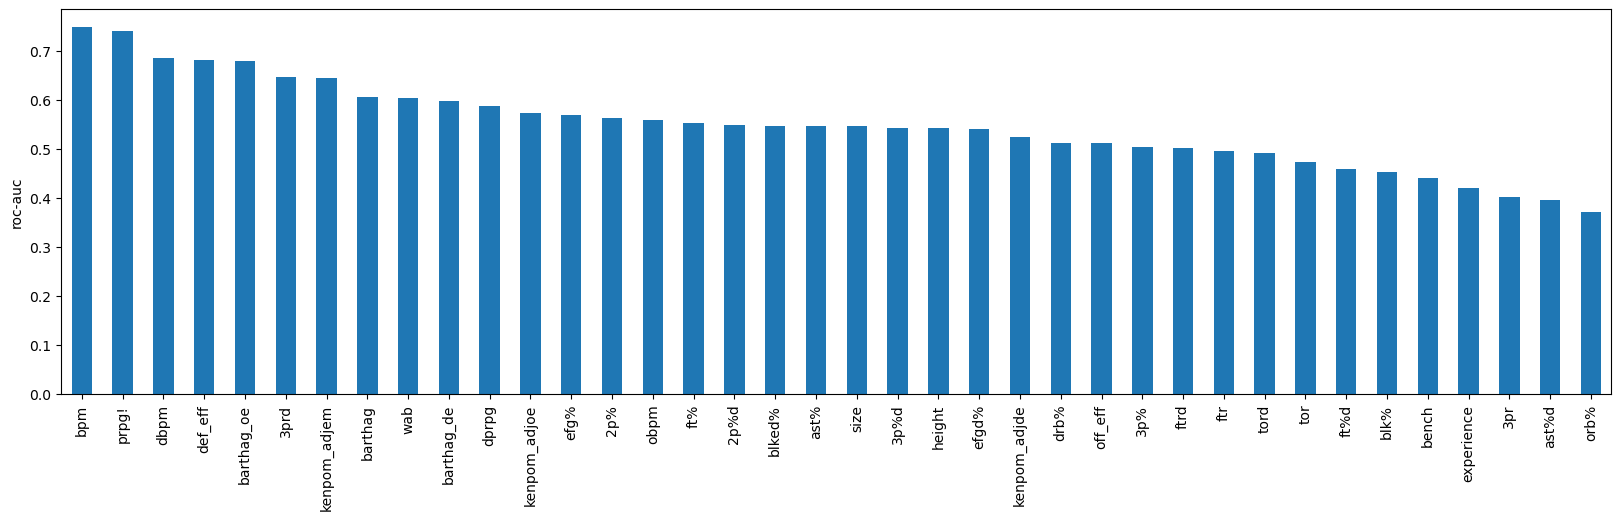

In [23]:
roc_values = pd.Series(roc_values)
roc_values.index = X_train.columns
roc_values.sort_values(ascending=False).plot.bar(figsize=(20, 5))
plt.ylabel('roc-auc')

In [24]:
len(roc_values[roc_values > 0.6])

9

In [25]:
roc_values[roc_values > 0.6]

wab            0.6042
prpg!          0.7413
bpm            0.7483
dbpm           0.6862
kenpom_adjem   0.6458
barthag        0.6059
barthag_oe     0.6788
def_eff        0.6823
3prd           0.6471
dtype: float64

In [26]:
roc_values[roc_values > 0.57]

wab            0.6042
prpg!          0.7413
dprpg          0.5868
bpm            0.7483
dbpm           0.6862
kenpom_adjem   0.6458
kenpom_adjoe   0.5729
barthag        0.6059
barthag_oe     0.6788
barthag_de     0.5990
def_eff        0.6823
efg%           0.5703
3prd           0.6471
dtype: float64

In [27]:
roc_values[roc_values > 0.55]

wab            0.6042
prpg!          0.7413
dprpg          0.5868
bpm            0.7483
obpm           0.5599
dbpm           0.6862
kenpom_adjem   0.6458
kenpom_adjoe   0.5729
barthag        0.6059
barthag_oe     0.6788
barthag_de     0.5990
def_eff        0.6823
efg%           0.5703
2p%            0.5634
ft%            0.5525
3prd           0.6471
dtype: float64

# III. XGBoost

In [58]:
X_train_scaled2 = X_train_scaled[[
'prpg!',
'bpm',
'dbpm',
'kenpom_adjem',
'barthag_oe',
#'barthag_de',
'def_eff',
'efg%',
#'3prd',
'ftrd',
'size',
'bench'
]]

X_test_scaled2 = X_test_scaled[[
'prpg!',
'bpm',
'dbpm',
'kenpom_adjem',
'barthag_oe',
#'barthag_de',
'def_eff',
'efg%',
#'3prd',
'ftrd',
'size',
'bench'
]]

In [59]:
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import log_loss

xgb_model = xgb.XGBClassifier(objective='binary:logistic', eval_metric='logloss')

# Set up hyperparameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [200, 300, 400, 500, 1000],
    'subsample': [0.1, 0.2, 0.3, 0.4],
    'colsample_bytree': [0.3, 0.4, 0.5, 0.6],
    'gamma': [0.2, 0.3, 0.4]
}

# Set up GridSearchCV
grid_search = GridSearchCV(estimator=xgb_model, param_grid=param_grid, 
                           scoring='neg_log_loss', cv=5, verbose=1, n_jobs=-1)

# Fit grid search
grid_search.fit(X_train_scaled2, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print(f"Best Hyperparameters: {best_params}")

Fitting 5 folds for each of 2880 candidates, totalling 14400 fits
Best Hyperparameters: {'colsample_bytree': 0.3, 'gamma': 0.3, 'learning_rate': 0.01, 'max_depth': 2, 'n_estimators': 400, 'subsample': 0.3}


In [60]:
# Retrain the model with the best parameters
best_xgb_model = xgb.XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    **best_params
)

best_xgb_model.fit(X_train_scaled2, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.3, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=0.3, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.01, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=400,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [61]:
# Predict probabilities
y_pred_proba = best_xgb_model.predict_proba(X_test_scaled2)[:, 1]

# Calculate Log Loss
logloss = log_loss(y_test, y_pred_proba)
print(f"Log Loss on test set: {logloss}")

Log Loss on test set: 0.5348897351551488


In [62]:
# Predictions
y_train_pred = best_xgb_model.predict(X_train_scaled2)
y_test_pred = best_xgb_model.predict(X_test_scaled2)

# Calculate accuracy scores
acc_train = accuracy_score(y_train, y_train_pred)
acc_test = accuracy_score(y_test, y_test_pred)

print(f"F1 Score on Training Data: {acc_train:.2f}")
print(f"F1 Score on Test Data: {acc_test:.2f}")

F1 Score on Training Data: 0.83
F1 Score on Test Data: 0.76


<Figure size 1000x600 with 0 Axes>

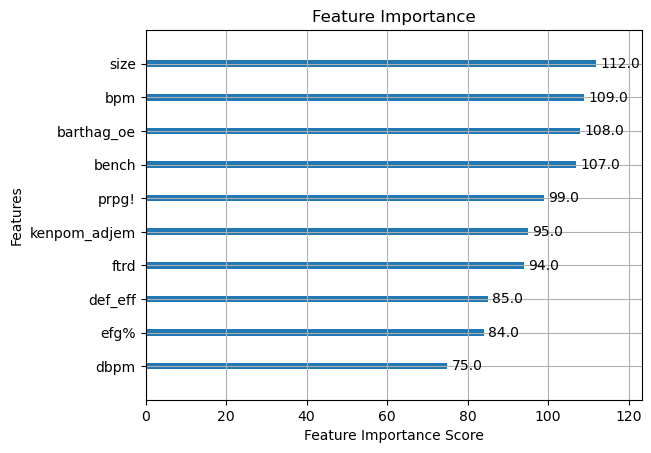

In [63]:
from xgboost import plot_importance

# Extract feature importance
feature_importance = best_xgb_model.get_booster().get_score(importance_type='weight')

# Visualize feature importance
plt.figure(figsize=(10, 6))
plot_importance(best_xgb_model, importance_type='weight', show_values=True, xlabel='Feature Importance Score')
plt.title('Feature Importance')
plt.show()